# 0. Library Import

In [1]:
# 한글 폰트 다운로드
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
0 upgraded, 0 newly installed, 0 to remove and 22 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/usr/share/fonts/truetype/n

In [2]:
# 지도 시각화 라이브러리 다운로드 
!pip install geopandas 
!pip install fiona

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import folium 
import requests
import json
import os
from tqdm import tqdm
import geopandas as gpd  
import fiona 
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pyproj
from fiona.crs import from_epsg

# 시각화 폰트 설정 
plt.rcParams['font.family'] ='NanumSquareRound'
plt.rc('font', size=20)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 50.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1.데이터

## 1.1 사용 데이터

1) [서울 시민생활 데이터-행정동단위 10개 관심집단수](https://data.seoul.go.kr/dataVisual/seoul/seoulLiving.do)

2) [서울시 1인가구(연령별) 통계](https://data.seoul.go.kr/dataList/10995/S/2/datasetView.do)

## 1.2 데이터 불러오기

#### 구글드라이브 마운트

In [3]:
from google.colab import drive
drive.mount('/content/drive') 

Mounted at /content/drive


#### 사용 데이터셋 불러오기

In [4]:
# 서울 시민 생활 데이터 - 행정동 단위 10개 관심집단 수 (2021.01 ~ 2022.01)
df = pd.read_csv("drive/MyDrive/12Team/data/total_interesting.csv")

# 지역 별 연령 별 1인가구 수 (2016~2021) 
df_year = pd.read_excel("drive/MyDrive/12Team/data/1인가구_연령별.xlsx")

# 서울시 행정구역 시군구 정보 (위도, 경도)
df_info = pd.read_csv("drive/MyDrive/12Team/data/서울시_행정구역_시군구_정보.csv")

df.head()

/usr/local/lib/python3.9/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


,행정동코드,자치구,행정동명,성별,연령대,총인구,1인가구수,커뮤니케이션이 적은 집단,평일 외출이 적은 집단,휴일 외출이 적은 집단,출근소요시간 및 근무시간이 많은 집단,외출이 매우 적은 집단(전체),외출이 매우 많은 집단,동영상서비스 이용이 많은 집단,생활서비스 이용이 많은 집단,재정상태에 대한 관심집단,외출-커뮤니케이션이 모두 적은 집단(전체)
0,1101053,종로구,사직동,1,20,221.00,51.97,8.335199,5.796584,7.415139,5.552525,4.166128,4.89,7.638924,1.961916,3.961066,2.067203
1,1101053,종로구,사직동,1,25,321.00,109.52,11.470799,11.454176,7.532451,11.114420,4.869294,12.95,10.347566,19.109366,16.766866,2.405569
2,1101053,종로구,사직동,1,30,351.11,107.71,15.288244,15.401204,9.599103,11.075590,9.442518,20.05,14.181075,10.767105,13.375326,6.666862
3,1101053,종로구,사직동,1,35,353.00,106.53,16.389481,10.787259,7.525317,10.245072,11.536156,15.33,16.540153,9.957706,7.537253,13.037654
4,1101053,종로구,사직동,1,40,419.00,80.24,13.778743,6.035512,11.261931,5.563842,7.523350,10.97,7.483620,5.407695,8.732050,11.160781


---------------

# 2.데이터 확인

### 2.1 서울 시민생활 데이터-행정동단위 10개 관심집단수 데이터

In [5]:
display(df.head())

,행정동코드,자치구,행정동명,성별,연령대,총인구,1인가구수,커뮤니케이션이 적은 집단,평일 외출이 적은 집단,휴일 외출이 적은 집단,출근소요시간 및 근무시간이 많은 집단,외출이 매우 적은 집단(전체),외출이 매우 많은 집단,동영상서비스 이용이 많은 집단,생활서비스 이용이 많은 집단,재정상태에 대한 관심집단,외출-커뮤니케이션이 모두 적은 집단(전체)
0,1101053,종로구,사직동,1,20,221.00,51.97,8.335199,5.796584,7.415139,5.552525,4.166128,4.89,7.638924,1.961916,3.961066,2.067203
1,1101053,종로구,사직동,1,25,321.00,109.52,11.470799,11.454176,7.532451,11.114420,4.869294,12.95,10.347566,19.109366,16.766866,2.405569
2,1101053,종로구,사직동,1,30,351.11,107.71,15.288244,15.401204,9.599103,11.075590,9.442518,20.05,14.181075,10.767105,13.375326,6.666862
3,1101053,종로구,사직동,1,35,353.00,106.53,16.389481,10.787259,7.525317,10.245072,11.536156,15.33,16.540153,9.957706,7.537253,13.037654
4,1101053,종로구,사직동,1,40,419.00,80.24,13.778743,6.035512,11.261931,5.563842,7.523350,10.97,7.483620,5.407695,8.732050,11.160781


In [6]:
print("===== 데이터 크기 =====")
print(df.shape)

print()
print("===== 데이터 정보 =====")
print(df.info())

print()
print("===== 결측값 확인 =====")
print(df.isnull().sum())

===== 데이터 크기 =====
(111936, 17)

===== 데이터 정보 =====
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111936 entries, 0 to 111935
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   행정동코드                    111936 non-null  int64  
 1   자치구                      111936 non-null  object 
 2   행정동명                     111936 non-null  object 
 3   성별                       111936 non-null  int64  
 4   연령대                      111936 non-null  int64  
 5   총인구                      111936 non-null  float64
 6   1인가구수                    111936 non-null  float64
 7   커뮤니케이션이 적은 집단            111936 non-null  float64
 8   평일 외출이 적은 집단             111936 non-null  float64
 9   휴일 외출이 적은 집단             111936 non-null  float64
 10  출근소요시간 및 근무시간이 많은 집단     111936 non-null  float64
 11  외출이 매우 적은 집단(전체)         111936 non-null  float64
 12  외출이 매우 많은 집단             111936 non-null  float64
 13  동영상서비스 

---------

### 2.2 서울시 1인가구(연령별) 통계 데이터
데이터를 사용하기 위해 전처리가 필요합니다. (데이터 전처리 단계에서 진행)

In [7]:
df_year.head()

,자치구별(1),자치구별(2),2016,2016.1,2016.2,2016.3,2016.4,2016.5,2016.6,2016.7,...,2021.6,2021.7,2021.8,2021.9,2021.10,2021.11,2021.12,2021.13,2021.14,2021.15
0,자치구별(1),자치구별(2),합계,합계,합계,합계,합계,합계,합계,합계,...,합계,합계,합계,합계,합계,합계,합계,합계,합계,합계
1,자치구별(1),자치구별(2),소계,20세미만,20~24세,25~29세,30~34세,35~39세,40~44세,45~49세,...,40~44세,45~49세,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85세이상
2,자치구별(1),자치구별(2),계,계,계,계,계,계,계,계,...,계,계,계,계,계,계,계,계,계,계
3,합계,소계,1138860,14937,101069,169534,152434,107045,88976,83763,...,99293,89640,89413,86500,102413,88494,69402,57061,42020,28407
4,합계,종로구,22835,526,2973,3547,2486,1723,1497,1633,...,1690,1620,1783,1757,1864,1546,1160,1133,811,597


# 3.EDA
`서울 시민생활 데이터-행정동단위 10개 관심집단수` 데이터로 어떤 분석과 시각화를 진행할 수 있을지 탐색합니다. **연령대별** 로 나누어 탐색을 진행합니다.

### 3.1 연령대 별 관심 집단 수 전체 히트맵
연령대 별로 전체 관심 집단 수 평균을 구하고, 전체적으로 각 연령대의 특정을 파악합니다.

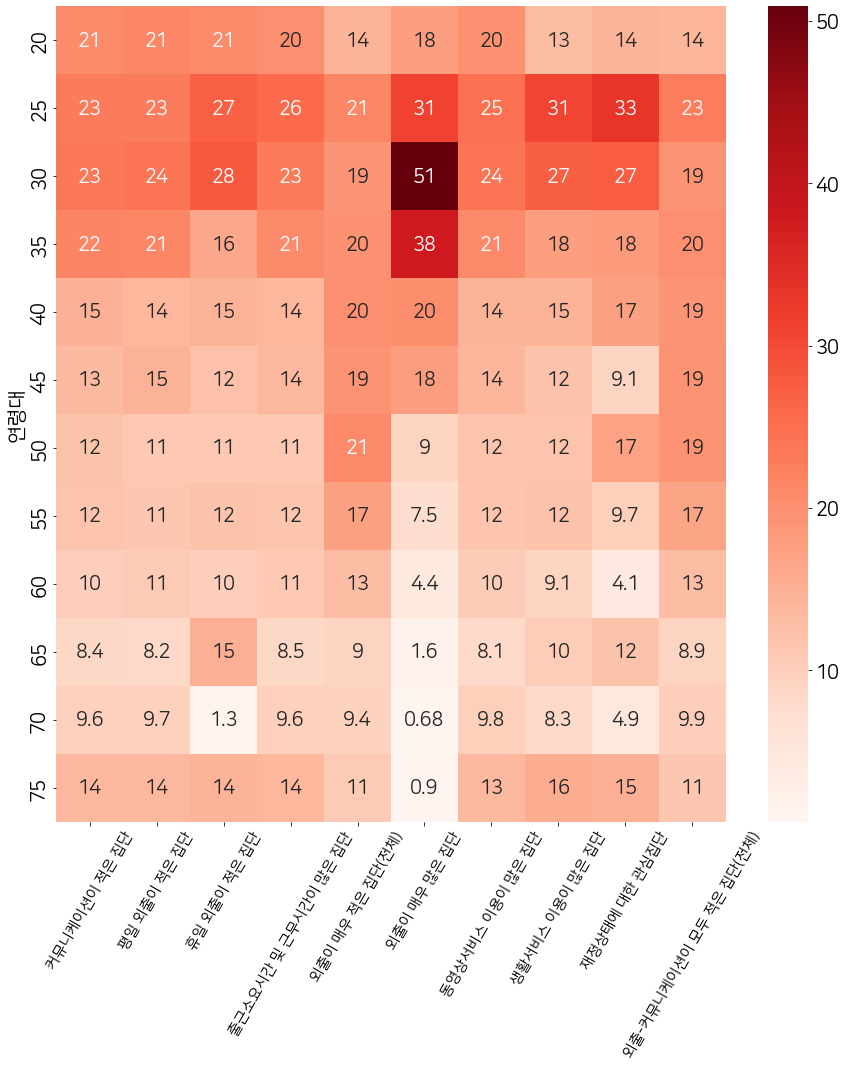

In [8]:
df2 = df.iloc[:, 4:].drop(columns=['총인구', '1인가구수']).groupby("연령대").mean()

plt.figure(figsize=(15, 15))
sns.heatmap(df2, cmap='Reds', annot=True)
_ = plt.xticks(fontsize=15, rotation=60)

대체적으로 20\~30에 집중되어있고, 40대 이후의 연령대는 수치가 낮습니다. 컬럼들의 내용을 보면, 20\~30대가 사회적 활동이 더 활발하다고 해석할 수 있습니다.  

### 3.2 연령대 별 외출과 커뮤니케이션이 적은 집단
위의 히트맵에서 사회적 접촉과 관련되어있는 커뮤니케이션, 외출, 서비스 관련 컬럼들만 뽑아서 다시 시각화합니다.

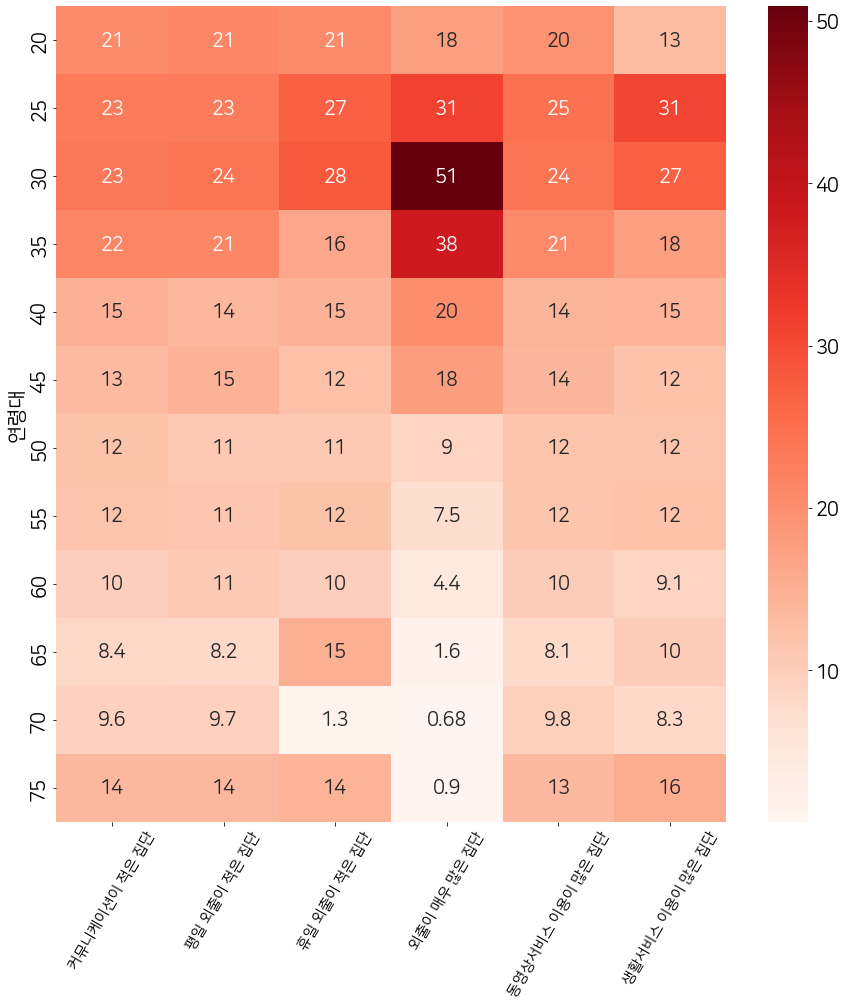

In [9]:
df3 = df.groupby("연령대")[["커뮤니케이션이 적은 집단", '평일 외출이 적은 집단', '휴일 외출이 적은 집단', "외출이 매우 많은 집단", "동영상서비스 이용이 많은 집단", "생활서비스 이용이 많은 집단"]].mean()

plt.figure(figsize=(15, 15))
sns.heatmap(df3, cmap='Reds', annot=True)
_ = plt.xticks(fontsize=15, rotation=60)

연령대가 높아질 수록 대체적으로 커뮤니케이션 및 외출이 적고, 생활서비스 이용도 적은 것으로 나타났습니다. 

### 3.3 연령대 별 1인 가구 수  
연령대 별 총 인구 수 대비 1인 가구 수와 연령대 별 1인가구의 비율을 시각화하여 어느 연령대에 1인 가구가 많이 존재하는지 확인합니다. 

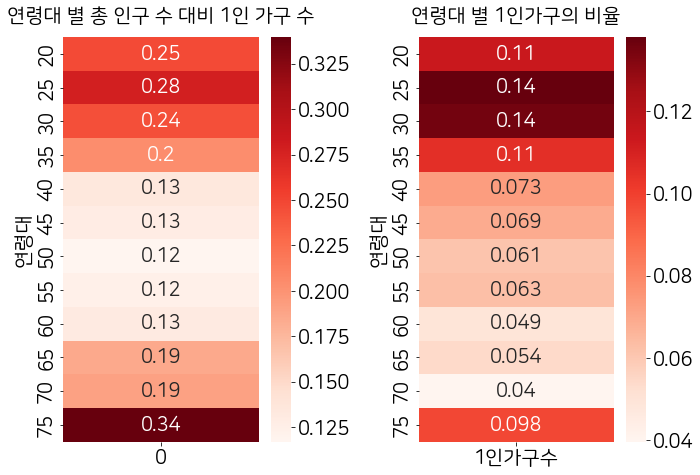

In [10]:
fig = plt.figure(figsize=(10, 7))
ax1, ax2 = fig.subplots(1, 2)

# 연령대 별 총 인구 수 대비 1인 가구 수
sr1 = df.groupby("연령대")['1인가구수'].mean() / df.groupby("연령대")['총인구'].mean()
sns.heatmap(sr1.to_frame(), cmap='Reds', annot=True, ax=ax1)
ax1.set_title("연령대 별 총 인구 수 대비 1인 가구 수", pad=15, fontsize=20)

# 연령대 별 1인가구의 비율
sr2 = df.groupby("연령대")['1인가구수'].sum() / df['1인가구수'].sum()
sns.heatmap(sr2.to_frame(), cmap='Reds', annot=True, ax=ax2)
ax2.set_title("연령대 별 1인가구의 비율", pad=15, fontsize=20)

fig.tight_layout()
plt.show()

연령대가 낮을 수록 1인 가구 수의 비율이 높고, 노년층에서 다시 증가하는 추세를 보입니다.

### 3.4 이상치 확인


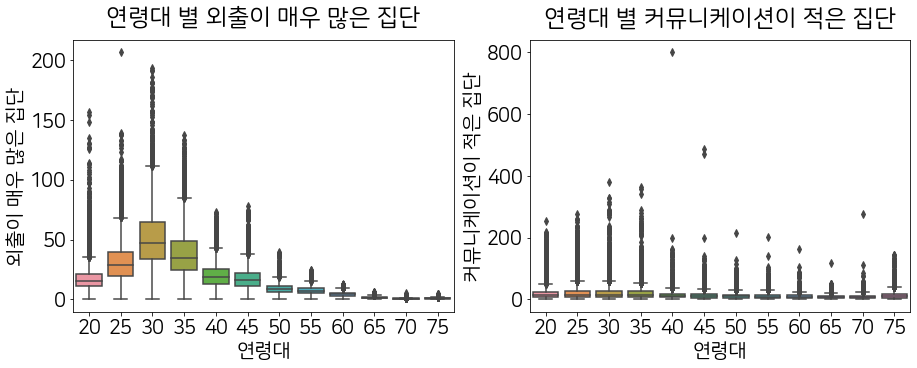

In [11]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1, 2)

ax1.set_title("연령대 별 외출이 매우 많은 집단", pad=15)
_=sns.boxplot(data=df, x='연령대', y="외출이 매우 많은 집단", ax=ax1)

ax2.set_title("연령대 별 커뮤니케이션이 적은 집단", pad=15)
_=sns.boxplot(data=df, x='연령대', y="커뮤니케이션이 적은 집단", ax=ax2)

`외출이 매우 많은 집단`, `커뮤니케이션이 적은 집단` 컬럼에 대해서 boxplot을 그려봤을 때 평균이나 중앙값 보다 훨씬 큰 수의 데이터가 다량 있는 것으로 보입니다. 데이터 분석 및 시각화를 진행할 때 왜곡된 결과를 보일 수 있으므로, IQR 방식을 사용해서 이상치의 범위에 있는 데이터들을 데이터 전처리 단계에서 삭제합니다. 

----------------

# 4.데이터 전처리

## 4.1 서울 시민생활 데이터-행정동단위 10개 관심집단수 데이터

In [12]:
# 원본 데이터를 카피하여 사용합니다. 
df_main = df.copy() 
print("df_main shape: ", df_main.shape)
display(df_main.head())

df_main shape:  (111936, 17)


,행정동코드,자치구,행정동명,성별,연령대,총인구,1인가구수,커뮤니케이션이 적은 집단,평일 외출이 적은 집단,휴일 외출이 적은 집단,출근소요시간 및 근무시간이 많은 집단,외출이 매우 적은 집단(전체),외출이 매우 많은 집단,동영상서비스 이용이 많은 집단,생활서비스 이용이 많은 집단,재정상태에 대한 관심집단,외출-커뮤니케이션이 모두 적은 집단(전체)
0,1101053,종로구,사직동,1,20,221.00,51.97,8.335199,5.796584,7.415139,5.552525,4.166128,4.89,7.638924,1.961916,3.961066,2.067203
1,1101053,종로구,사직동,1,25,321.00,109.52,11.470799,11.454176,7.532451,11.114420,4.869294,12.95,10.347566,19.109366,16.766866,2.405569
2,1101053,종로구,사직동,1,30,351.11,107.71,15.288244,15.401204,9.599103,11.075590,9.442518,20.05,14.181075,10.767105,13.375326,6.666862
3,1101053,종로구,사직동,1,35,353.00,106.53,16.389481,10.787259,7.525317,10.245072,11.536156,15.33,16.540153,9.957706,7.537253,13.037654
4,1101053,종로구,사직동,1,40,419.00,80.24,13.778743,6.035512,11.261931,5.563842,7.523350,10.97,7.483620,5.407695,8.732050,11.160781


### 4.1.1 연령대 별 병합
`20대(초기청년층) - 20` /  `30대 (후기 청년층) - 30` / `40대 (중년층) - 40` / `50~64(장년층) - 50` / `65세 이상 (노년층) - 60` 으로 연령대를 병합합니다. 

In [13]:
def age_merge(x): 
  if 20 <= x < 30: 
    return 20 
  elif 20 <= x < 40: 
    return 30 
  elif 40 <= x < 50: 
    return 40
  elif 50 <= x < 65: 
    return 50 
  else: 
    return 60 

df_main["연령대"] = df_main['연령대'].apply(age_merge)

# 확인
df_main['연령대'].unique() 

array([20, 30, 40, 50, 60])

### 4.1.2 이상치 제거 


- 이상치 제거 전 boxplot 

연령대 별 병합을 진행했으므로 다시 boxplot을 그려보고 이상치를 파악한 후, 연령대별로 제거합니다. 

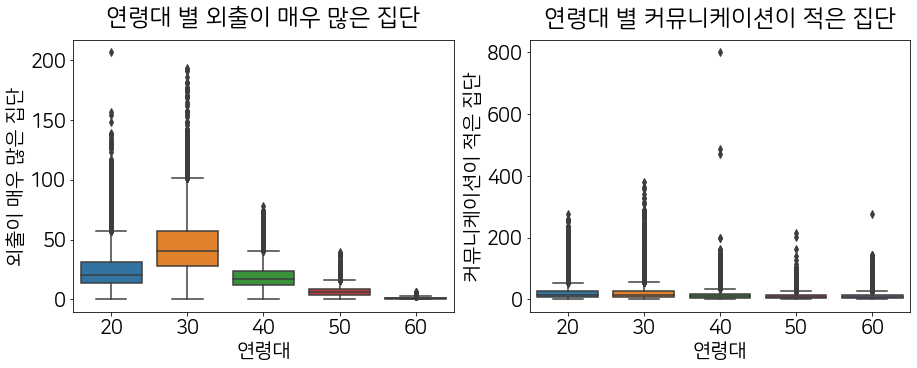

In [14]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1, 2)

ax1.set_title("연령대 별 외출이 매우 많은 집단", pad=15)
_=sns.boxplot(data=df_main, x='연령대', y="외출이 매우 많은 집단", ax=ax1)

ax2.set_title("연령대 별 커뮤니케이션이 적은 집단", pad=15)
_=sns.boxplot(data=df_main, x='연령대', y="커뮤니케이션이 적은 집단", ax=ax2)

- 외출이 매우 많은 집단 연령대 별 이상치 제거 

이상치 제거에는 IQR 방식을 사용합니다. 

In [15]:
outlier_out_cnt = 0 
print("원본 데이터 개수: ", df_main.size)

for age in df_main["연령대"].unique():
  df_out_age = df_main[df_main["연령대"] == age]['외출이 매우 많은 집단']
  Q1 = df_out_age.quantile(0.25)
  Q3 = df_out_age.quantile(0.75)
  IQR = Q3 - Q1

  df_out_age_outlier = df_out_age[(df_out_age >= Q3 + 1.5*IQR) | (df_out_age <= Q1 - 1.5*IQR)]
  outlier_out_cnt += df_out_age_outlier.size
  df_main = df_main.drop(index=df_out_age_outlier.index)
  
print("이상치 개수: ", outlier_out_cnt)
print("이상치 제거 후 데이터 개수: ", df_main.size)

원본 데이터 개수:  1902912
이상치 개수:  4017
이상치 제거 후 데이터 개수:  1834623


- 커뮤니케이션이 적은 집단 연령대 별 이상치 제거 

In [16]:
outlier_com_cnt = 0 
print("원본 데이터 개수: ", df_main.size)

for age in df_main["연령대"].unique():
  df_com_age = df_main[df_main["연령대"] == age]['커뮤니케이션이 적은 집단']
  Q1 = df_com_age.quantile(0.25)
  Q3 = df_com_age.quantile(0.75)
  IQR = Q3 - Q1

  df_com_age_outlier = df_com_age[(df_com_age >= Q3 + 1.5*IQR) | (df_com_age <= Q1 - 1.5*IQR)]
  outlier_com_cnt += df_com_age_outlier.size
  df_main = df_main.drop(index=df_com_age_outlier.index)

print("이상치 개수: ", outlier_com_cnt)
print("이상치 제거 후 데이터 개수: ", df_main.size)

원본 데이터 개수:  1834623
이상치 개수:  6079
이상치 제거 후 데이터 개수:  1731280


- 이상치 제거 후 boxplot 

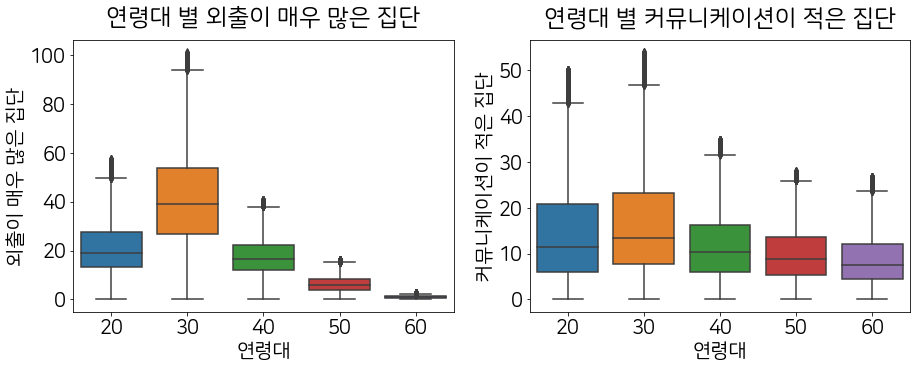

In [17]:
fig = plt.figure(figsize=(15, 5))
ax1, ax2 = fig.subplots(1, 2)

ax1.set_title("연령대 별 외출이 매우 많은 집단", pad=15)
_=sns.boxplot(data=df_main, x='연령대', y="외출이 매우 많은 집단", ax=ax1)

ax2.set_title("연령대 별 커뮤니케이션이 적은 집단", pad=15)
_=sns.boxplot(data=df_main, x='연령대', y="커뮤니케이션이 적은 집단", ax=ax2)

### 4.1.3 스케일링
 시각화에서 같은 범위에서 비교해보기 위해 외출이 매우 많은 집단의 외출 지수와, 커뮤니케이션이 적은 집단의 커뮤니케이션 지수의 스케일을 0~1로 같게 만듭니다.  
- 생성 컬럼 명: `out_sclaed`, `com_scaled`

In [18]:
out_min, out_max = df_main["외출이 매우 많은 집단"].min(), df_main["외출이 매우 많은 집단"].max()
com_min, com_max = df_main["커뮤니케이션이 적은 집단"].min(), df_main["커뮤니케이션이 적은 집단"].max()

df_main["out_scaled"] = df_main["외출이 매우 많은 집단"].apply(lambda x: (x-out_min) / (out_max - out_min))
df_main["com_scaled"] = df_main["커뮤니케이션이 적은 집단"].apply(lambda x: (x-com_min) / (com_max - com_min))

# 확인 
print("외출이 매우 많은 집단: ", df_main["out_scaled"].min(), df_main["out_scaled"].max())
print("커뮤니케이션이 적은 집단: ", df_main["com_scaled"].min(), df_main["com_scaled"].max())

외출이 매우 많은 집단:  0.0 1.0
커뮤니케이션이 적은 집단:  0.0 1.0


## 4.2 서울시 1인가구(연령별) 통계 데이터

In [19]:
# 원본 데이터를 카피하여 사용합니다. 
df_2016_2021 = df_year.copy() 
print("df_2016_2021 shape: ", df_2016_2021.shape)
display(df_2016_2021.head())

df_2016_2021 shape:  (29, 98)


,자치구별(1),자치구별(2),2016,2016.1,2016.2,2016.3,2016.4,2016.5,2016.6,2016.7,...,2021.6,2021.7,2021.8,2021.9,2021.10,2021.11,2021.12,2021.13,2021.14,2021.15
0,자치구별(1),자치구별(2),합계,합계,합계,합계,합계,합계,합계,합계,...,합계,합계,합계,합계,합계,합계,합계,합계,합계,합계
1,자치구별(1),자치구별(2),소계,20세미만,20~24세,25~29세,30~34세,35~39세,40~44세,45~49세,...,40~44세,45~49세,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85세이상
2,자치구별(1),자치구별(2),계,계,계,계,계,계,계,계,...,계,계,계,계,계,계,계,계,계,계
3,합계,소계,1138860,14937,101069,169534,152434,107045,88976,83763,...,99293,89640,89413,86500,102413,88494,69402,57061,42020,28407
4,합계,종로구,22835,526,2973,3547,2486,1723,1497,1633,...,1690,1620,1783,1757,1864,1546,1160,1133,811,597


### 4.2.1 연도 별 연령 별 1인 가구 수 기본 전처리 
제공되는 데이터의 형태가 정제되어있지 않아서 데이터 분석이 가능한 형태로 전처리합니다.

- 필요 없는 열, 행 삭제 (자치구별, 소계, 합계, 계 포함된 데이터) 

In [20]:
df_2016_2021 = df_2016_2021.drop(columns=["자치구별(1)"]).drop([0, 2, 3])

- 컬럼 년도 전처리   

1행의 연령대 별로 년도 뒤에 숫자가 붙어있는 것을 삭제합니다.

In [21]:
lst_year = list(range(2016, 2022))
lst_num = list(range(1, 16))

# 연도 합계 삭제 
for year in lst_year: 
  df_2016_2021 = df_2016_2021.drop(columns=[str(year)])

# 연도 이름 통일 
for year in lst_year: 
  for num in lst_num:
    df_2016_2021 = df_2016_2021.rename(columns={f"{year}.{num}" : f'{year}'})

df_2016_2021.head()

,자치구별(2),2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
1,자치구별(2),20세미만,20~24세,25~29세,30~34세,35~39세,40~44세,45~49세,50~54세,55~59세,...,40~44세,45~49세,50~54세,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85세이상
4,종로구,526,2973,3547,2486,1723,1497,1633,1544,1537,...,1690,1620,1783,1757,1864,1546,1160,1133,811,597
5,중구,567,2061,2521,2140,1595,1461,1575,1391,1482,...,1607,1486,1609,1540,1728,1567,1168,962,762,555
6,용산구,250,2591,4108,4316,3191,2771,2604,2090,2102,...,3106,2624,2451,2166,2364,1925,1466,1335,1117,899
7,성동구,878,4276,5706,4400,3225,2824,2833,2561,2548,...,3011,2773,2822,2721,3078,2464,1854,1666,1252,773


- 연령대 컬럼 처리 및 연도 컬럼 생성 

In [22]:
# 연령대 컬럼을 만들기 위해 행 따로 추출 
df_2016_2021 = df_2016_2021.rename(columns={'자치구별(2)': "자치구"})
age = df_2016_2021.loc[1]
df_2016_2021 = df_2016_2021.drop(1)
print("== 필요 없는 column, row 삭제 후 ==")
display(df_2016_2021.head() )

# 연도 컬럼 녹이기
df_melt = df_2016_2021.melt(id_vars=['자치구']).rename(columns={"variable": '연도', "value": "1인가구수"}).sort_values(by=['자치구', '연도'])

# 연령대 컬럼 추가 
df_melt['연령대'] = age.iloc[1:].values.tolist()*25

print()
print("== 연도 녹이고 연령대 추가 ==")
display(df_melt.head())

== 필요 없는 column, row 삭제 후 ==


,자치구,2016,2016,2016,2016,2016,2016,2016,2016,2016,...,2021,2021,2021,2021,2021,2021,2021,2021,2021,2021
4,종로구,526,2973,3547,2486,1723,1497,1633,1544,1537,...,1690,1620,1783,1757,1864,1546,1160,1133,811,597
5,중구,567,2061,2521,2140,1595,1461,1575,1391,1482,...,1607,1486,1609,1540,1728,1567,1168,962,762,555
6,용산구,250,2591,4108,4316,3191,2771,2604,2090,2102,...,3106,2624,2451,2166,2364,1925,1466,1335,1117,899
7,성동구,878,4276,5706,4400,3225,2824,2833,2561,2548,...,3011,2773,2822,2721,3078,2464,1854,1666,1252,773
8,광진구,805,6136,9929,8069,5156,3903,3680,3278,3292,...,4257,3554,3738,3608,3969,3023,2184,1764,1216,806



== 연도 녹이고 연령대 추가 ==


,자치구,연도,1인가구수,연령대
22,강남구,2016,572,20세미만
47,강남구,2016,3290,20~24세
72,강남구,2016,9652,25~29세
97,강남구,2016,11904,30~34세
122,강남구,2016,8747,35~39세


- **df_melt:** 자치구, 연도, 1인가구수, 연령대 컬럼 존재 - 지역별, 연도별, 연령대별 분석을 위한 데이터셋 

In [23]:
df_melt = df_melt.reset_index(drop=True)
print("df_melt shape: ", df_melt.shape)
display(df_melt.head())

df_melt shape:  (2250, 4)


,자치구,연도,1인가구수,연령대
0,강남구,2016,572,20세미만
1,강남구,2016,3290,20~24세
2,강남구,2016,9652,25~29세
3,강남구,2016,11904,30~34세
4,강남구,2016,8747,35~39세


- **df_total:** 연도 지역 별 별 연령대 별 데이터셋  

In [24]:
df_total = df_melt.pivot_table(index=['연도', '자치구'], columns='연령대')
print("df_total shape: ", df_total.shape)
display(df_total.head())

df_total shape:  (150, 15)


1인가구수                                                             \
연령대        20~24세   20세미만   25~29세   30~34세   35~39세  40~44세  45~49세  50~54세   
연도   자치구                                                                       
2016 강남구   3290.0   572.0   9652.0  11904.0   8747.0  5937.0  4585.0  3313.0   
     강동구   1453.0   158.0   4187.0   4865.0   3929.0  3415.0  3456.0  3442.0   
     강북구   1814.0   199.0   3119.0   3258.0   2892.0  2804.0  3089.0  3211.0   
     강서구   2839.0   279.0   8418.0   8827.0   6333.0  5100.0  4440.0  4049.0   
     관악구  12313.0  1053.0  25782.0  18425.0  10026.0  7119.0  5673.0  4635.0   

                                                                  
연령대       55~59세  60~64세  65~69세  70~74세  75~79세  80~84세   85세이상  
연도   자치구                                                          
2016 강남구  3181.0  2911.0  2484.0  2016.0  1518.0  1011.0   877.0  
     강동구  3679.0  3305.0  2532.0  1887.0  1477.0  1010.0   674.0  
     강북구  3548.0  3232.0  2887.0  2618.0  2079.0  1251.0   667.0  
     강서구  4872.0  4362.0  3534.0  2877.0  2368.0  1589.0  1101.0  
     관악구  4627.0  3986.0  3294.0  2836.0  2261.0  1205.0   737.0

### 4.2.2 연령대 별 병합
`20세미만(미성년자) - 10` / `20대(초기청년층) - 20` /  `30대 (후기 청년층) - 30` / `40대 (중년층) - 40` / `50~64(장년층) - 50` / `65세 이상 (노년층) - 60` 으로 나누어 연령대를 병합합니다. 

In [25]:
# 20세 미만은 10대로 구분 
df_melt["연령대"] = df_melt["연령대"].str.replace("20세미만", "10")

# 연령대 분리 
df_melt['연령대'] = df_melt['연령대'].str.replace('세|이상', "").str.split("~")

def age_merge2(lst_age): 
  x = int(lst_age[0])
  if x <= 10:
    return 10 
  elif 20 <= x < 30: 
    return 20 
  elif 20 <= x < 40: 
    return 30 
  elif 40 <= x < 50: 
    return 40
  elif 50 <= x < 65: 
    return 50 
  else: 
    return 60 

df_melt["연령대"] = df_melt['연령대'].apply(age_merge2)

# 확인
df_melt['연령대'].unique() 

<ipython-input-25-ef518943cc09>:5: FutureWarning: The default value of regex will change from True to False in a future version.
  df_melt['연령대'] = df_melt['연령대'].str.replace('세|이상', "").str.split("~")


array([10, 20, 30, 40, 50, 60])

---------

# 5.데이터 분석 / 시각화
위에서 얻은 인사이트를 토대로 주제에 맞는 데이터 시각화를 진행합니다.

<br>

----------

<br>

#### ▪️ 전처리 데이터셋 

  1. 서울 시민생활 데이터-행정동단위 10개 관심집단수 데이터
  - df_main  


  2. 서울시 1인가구(연령별) 통계 데이터
  - df_melt / df_total

<br>

---------

<br>

#### ▪️ 가설 설정
1. 1인 가구 추이: 1인 가구가 지속적으로 증가했을 것이다. 
2. 연령대가 높아질 수록 사회적 접촉이 감소할 것이다. 

<br>

---------

<br>

#### ▪️ 시각화 목록 
1. 지역 별 1인 가구 수 
2. 연도 별 1인 가구 추이 
3. 연령대 별 사회적 접촉 (연령대 별 외출이 많은 집단 + 연령대 별 커뮤니케이션 지수) 


<br>
<br>



### 5.1 지역 별 1인 가구 수
서울시 자치구 별 1인 가구 수의 단계구분도 시각화를 통해 서울시 전체의 1인 가구 수 현황을 파악합니다. 

- **choropleth (단계구분도)**

In [26]:
# 행정구역시군구_경계 데이터 
gdf_admin_gu_pg = gpd.read_file('drive/MyDrive/12Team/data/LARD_ADM_SECT_SGG_11.shp', encoding='cp949')  
gdf_admin_gu_pg.crs = "epsg:5179"

gdf_admin_gu_pg2 = gdf_admin_gu_pg.to_crs(epsg=3857) 
gdf_admin_gu_pg2["SGG_NM"] = gdf_admin_gu_pg2["SGG_NM"].astype("str")

gp = df_melt.groupby("자치구")['1인가구수'].sum().astype("int")
gdf_admin_gu_pg3 = gdf_admin_gu_pg2.rename(columns={"SGG_NM": "자치구"})
gdf_gu = pd.concat([gdf_admin_gu_pg3.set_index("자치구"), gp], axis=1).reset_index()

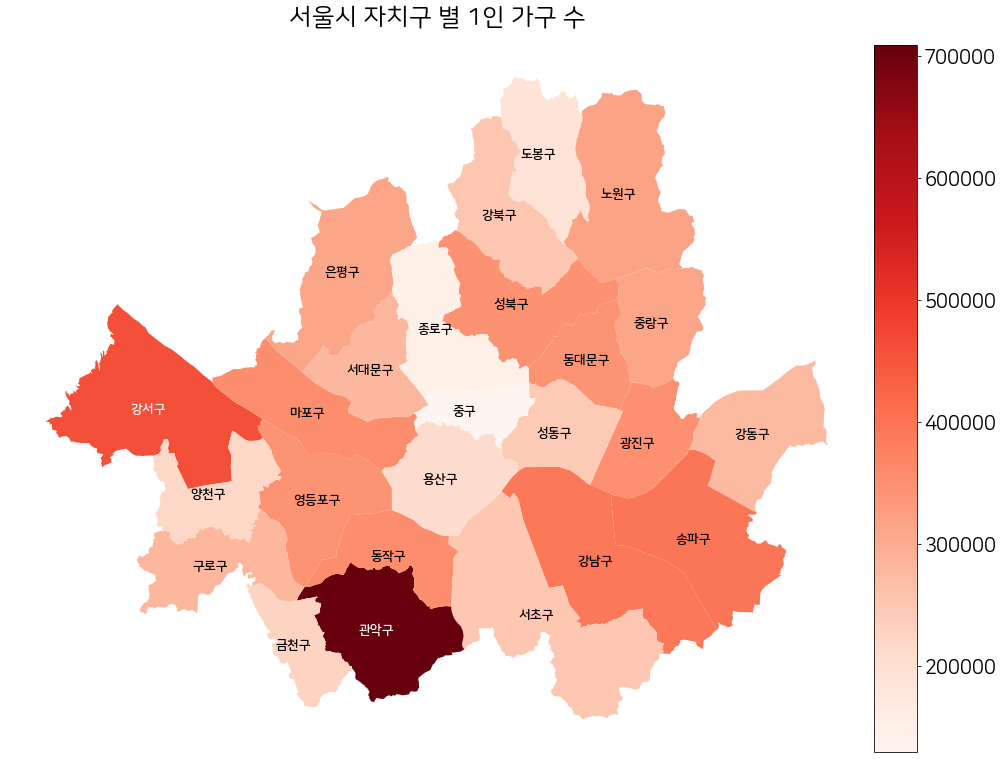

In [27]:
fig = plt.figure(figsize=(18, 13))
ax = fig.subplots(1, 1)

columns = ["자치구", "1인가구수"]
gdf_gu2 = gpd.GeoDataFrame(gdf_gu[columns], geometry=gdf_gu.geometry, crs=from_epsg(3857))
gdf_gu2["center"] = gdf_gu2.geometry.centroid


# 범례
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)

# 단계구분도
gdf_gu2.plot("1인가구수", ax=ax, legend=True,  cax=cax, cmap='Reds')
ax.set_title("서울시 자치구 별 1인 가구 수", fontsize=25, pad=20)

# 지역명 추가 
for idx in range(len(gdf_gu2)): 
  lat = gdf_gu2.center.iloc[idx].xy[0][0]
  long = gdf_gu2.center.iloc[idx].xy[1][0]
  
  if gdf_gu2["1인가구수"].iloc[idx] >= 400000:
    c = "white"
  else: 
    c = 'black'
  ax.text(lat-1500, long-300, gdf_gu2["자치구"].iloc[idx], fontsize=13, color=c,  fontweight='bold')

ax.set_axis_off()
plt.show()

관악구와 강서구는 다른 지역에 비해 색깔이 짙고, 종로구, 중구는 색이 옅게 나타납니다.

### 5.2 연도 별 1인 가구 추이

- **barplot + lineplot**

(0.0, 1800000.0)

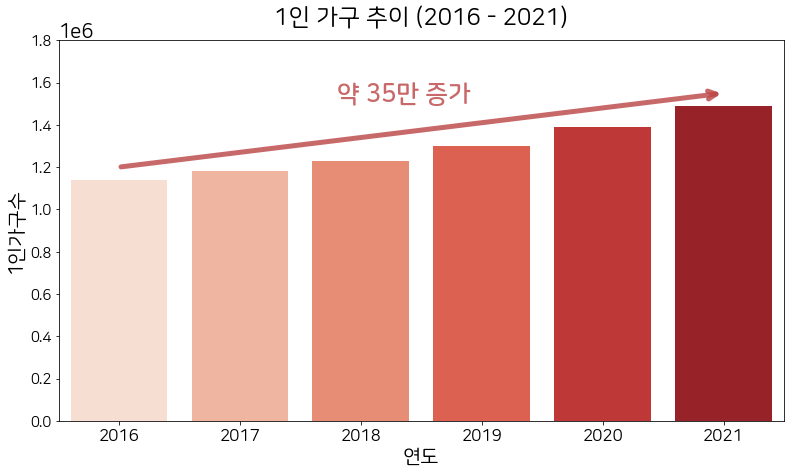

In [131]:
plt.figure(figsize=(13, 7))

plt.title("1인 가구 추이 (2016 - 2021)", pad=15)

sns.barplot(data = df_melt, x="연도", y="1인가구수", estimator=sum, ci=None, palette=sns.color_palette("Reds"))
# sns.lineplot(data = df_melt, x="연도", y="1인가구수", estimator=sum, ci=None, color='#CD5C5C', marker='o')


plt.annotate('',
              ha = 'center', va = 'bottom',
              xytext = (0, 1200000),
              xy = (5, 1550000),
              arrowprops = {
                            'edgecolor':'#bb4444', 
                            'alpha':0.8,
                            'arrowstyle':'->',
                            "lw": 5
                })

_=plt.text(1.8, 1510000, '약 35만 증가', fontsize=25, color='#bb4444', fontweight='heavy', alpha=0.8)

_ = plt.yticks(fontsize=15)
_ = plt.xticks(fontsize=17)

plt.ylim(0, 1800000)

연도 별로 1인 가구 수의 총 합을 시각화 해보았을 때, 지속적으로 1인가구 수가 증가하는 것을 확인할 수 있습니다. 

### 5.3 연령대 별 사회적 접촉


- **bar graph** : 연령대 별 각각의 외출, 커뮤니케이션 지수 값 

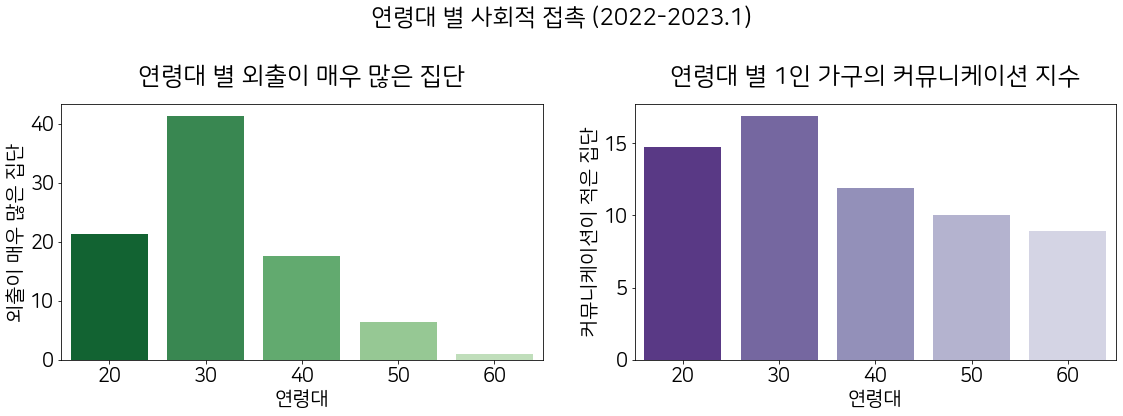

In [29]:
fig = plt.figure(figsize=(16, 6))
ax1, ax2 = fig.subplots(1, 2)

plt.suptitle("연령대 별 사회적 접촉 (2022-2023.1)")

ax1.set_title("연령대 별 외출이 매우 많은 집단", pad=20, fontsize=25)
_=sns.barplot(data=df_main, x='연령대', y='외출이 매우 많은 집단', palette=sns.color_palette("Greens_r"), ci=None, ax=ax1)

ax2.set_title("연령대 별 1인 가구의 커뮤니케이션 지수", pad=20, fontsize=25)
_=sns.barplot(data=df_main, x='연령대', y='커뮤니케이션이 적은 집단', palette=sns.color_palette("Purples_r"), ci=None, ax=ax2)

fig.tight_layout()

- **pie chart**: 각 지수의 연령대 별 비율

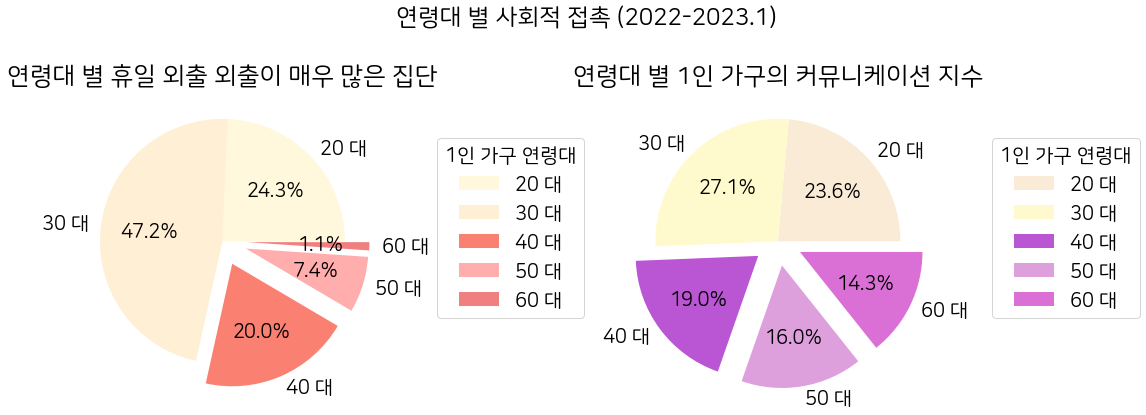

In [30]:
fig = plt.figure(figsize=(16, 6))
ax1, ax2 = fig.subplots(1, 2)

plt.suptitle("연령대 별 사회적 접촉 (2022-2023.1)")

df_age_out = df_main.groupby("연령대")['외출이 매우 많은 집단'].mean()
df_age_com = df_main.groupby("연령대")['커뮤니케이션이 적은 집단'].mean()

ax1.set_title("연령대 별 휴일 외출 외출이 매우 많은 집단", pad=5, fontsize=25)
_ = ax1.pie(
    df_age_out, 
    labels=[str(age)+" 대" for age in df_age_out.index], 
    autopct = '%.1f%%', 
    explode = [0, 0, 0.2, 0.2, 0.2],
    colors=['#FFF8DC','#FFEFD5','#FA8072', '#ffadad', '#F08080']) 

_ = ax1.legend(loc = (1.2, 0.25), title = '1인 가구 연령대')


ax2.set_title("연령대 별 1인 가구의 커뮤니케이션 지수", pad=5, fontsize=25)
_ = ax2.pie(
    df_age_com, 
    labels=[str(age)+" 대" for age in df_age_com.index], 
    autopct = '%.1f%%', 
    explode = [0, 0, 0.2, 0.2, 0.2],
    colors=['#FAEBD7','#FFFACD','#BA55D3', '#DDA0DD', '#DA70D6']) 

_ = ax2.legend(loc = (1.2, 0.25), title = '1인 가구 연령대')


fig.tight_layout()

- **barplot + pointplot:** 연령대 별 외출, 커뮤니케이션 지수 통합 그래프 (0~1 사이의 스케일 값) 

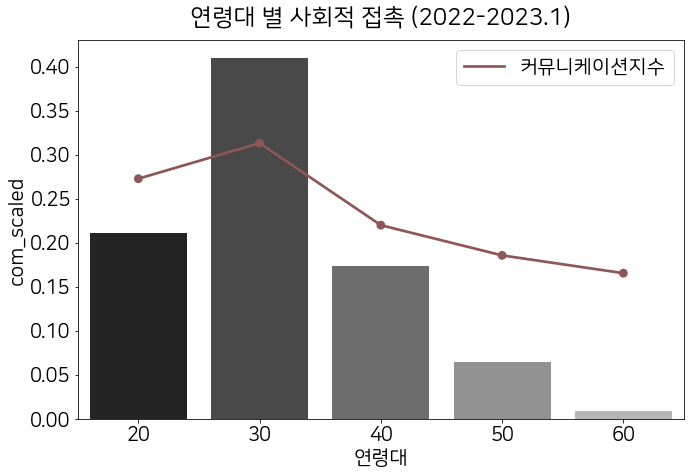

In [133]:
fig = plt.figure(figsize=(10, 7))
ax = fig.subplots(1, 1)

ax.set_title("연령대 별 사회적 접촉 (2022-2023.1)", pad=15)


_=sns.barplot(data=df_main, x='연령대', y='out_scaled', palette=sns.color_palette("gray"), ci=None, ax=ax, label="외출지수")
_=sns.pointplot(data=df_main, x='연령대', y='com_scaled', ci=None, ax=ax, color='#8d5757')

plt.legend(labels=["커뮤니케이션지수"])

fig.tight_layout()

연령대 별로 사회적 접촉량이 많은지 알아보기 위해 **외출이 매우 많은 집단**과 **커뮤니케이션 지수** 를 시각화 해보았을 때 두 가지 경우 모두 40대 이후로 감소하는 것을 확인할 수 있습니다.

------

# 6.데이터 분석 요약

### 1️. 연도 별 1인 가구 수 추이   
- **2016년~2022년 1인 가구수 총합**을 구하여 시간의 경과에 따른 변화량과 데이터지도를 그려봤을때, **연도별 1인 가구수는 지속적으로 증가**하고 있습니다.

<br>

### 2. 연령대 별 사회적 접촉  
- 2022년 이후 연령대별로 1인 가구의 **커뮤니케이션이 적은 집단을 비교해봤을 때, 중년층 이후 커뮤니케이션 지수가 감소**하는 경향을 보입니다.
  - `커뮤니케이션이 적은 집단 측정 기준:` 전화/문자 수 발신 대상자 수, 전화/문자 수 발신 건 수,
SNS 사용량 기준

- 2022년 이후 연령대 별 1인 가구의 **외출이 매우 많은 집단 데이터를 비교해봤을 때, 중년층 이후 외출이 감소**하는 경향을 보입니다. 
  - `외출이 매우 많은집단 측정 기준:` 1인가구 대상 근로소득이 3천만원 초과이고, 
휴일의 이동건수와 이동거리가 크고, 
휴일의 추정거주지 체류시간이 적은 사람 기준
(휴일 이동경향이 높은 대상자를 구분하기 위함)
